In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
ls

IMU_Data/     new_testfile.csv  Radar_Data/                  SensorConfig.docx
IMU_Streams/  plot.png          Radar_PostProcess_Heatmaps/  testfile.csv




---


Change Dir to Shared Drive that Contains RADAR Heatmap Images

In [ ]:
import os
os.chdir("/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/Data/")

In [ ]:
ls

IMU_Data/     new_testfile.csv  Radar_Data/                  SensorConfig.docx
IMU_Streams/  plot.png          Radar_PostProcess_Heatmaps/  testfile.csv




---
Install PyTorch and Ensure GPU is Working


In [ ]:
!pip3 install torch torchvision

In [ ]:
import glob
import cv2
import os
import os.path as osp
import time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torchvision import datasets

torch.cuda.empty_cache()

In [ ]:
a = torch.Tensor([1]).cuda()
print(a)

tensor([1.], device='cuda:0')


In [ ]:
torch.cuda.is_available()

True



---


Radar Heatmaps Custom Dataset

In [ ]:
class_map = {
    'bicyclerack': 0,
    'bush': 1,
    'firehydrant': 2,
    'human': 3,
    'lamppost': 4,
    'middle_of_sidewalk': 5,
    'tree': 6,
    'wall': 7
}


class CustomDataset(Dataset):

    def __init__(self, data_path, transform=None, target_transform=None):
        self.imgs_path = data_path
        file_list = glob.glob(self.imgs_path + '/*')
        #print('file list', file_list)

        self.data = []
        for class_path in file_list:
            class_name = class_path.split('/')[-1]
            # a class can have multiple scenarios (wall class -> glass wall, brick wall)
            for scenario_dir in glob.glob(class_path + '/' + '*'):
                scenario_dir_heatmaps_regex = 'allobjects_1m_*_noaxis.png'
                for img_path in glob.glob(scenario_dir + '/' + scenario_dir_heatmaps_regex):
                    self.data.append([img_path, class_name])

        
        self.class_map = class_map
        self.img_dim = (400, 200)
        self.transform = transform
        self.target_transform = target_transform
    
    
    def __len__(self):
        return len(self.data)

    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        target = self.class_map[class_name]
        #img_tensor = torch.from_numpy(img)
        #img_tensor = img_tensor.permute(2, 0, 1)
        # target = torch.tensor([target])
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target


In [ ]:
class_map = {
    'bicyclerack': 0,
    'bush': 1,
    'firehydrant': 2,
    'human': 3,
    'lamppost': 4,
    'middle_of_sidewalk': 5,
    'tree': 6,
    'wall': 7
}

object_vs_none = {'bicyclerack': 1,
                    'bush': 1,
                    'human': 1,
                    'lamppost': 1,
                    'middle_of_sidewalk': 0,
                    'tree': 1,
                    'wall': 1}

class ParkingDataset(Dataset):

    def __init__(self, data_path, class_map = object_vs_none, transform=None, target_transform=None):
        self.imgs_path = data_path
        file_list = glob.glob(self.imgs_path + '/*')
        #print('file list', file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split('/')[-1]
            # a class can have multiple scenarios (wall class -> glass wall, brick wall)
            for scenario_dir in glob.glob(class_path + '/' + '*'):
                scenario_dir_heatmaps_regex = 'allobjects_1m_*_noaxis.png'
                for img_path in glob.glob(scenario_dir + '/' + scenario_dir_heatmaps_regex):
                    if class_name not in self.class_map.keys():
                        pass
                    else:
                        self.data.append([img_path, class_name])

        
        self.class_map = class_map
        self.img_dim = (400, 200)
        self.transform = transform
        self.target_transform = target_transform
    
    
    def __len__(self):
        return len(self.data)

    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = cv2.imread(img_path)
        img = cv2.resize(img, self.img_dim)
        target = self.class_map[class_name]
        original_label = class_name
        #img_tensor = torch.from_numpy(img)
        #img_tensor = img_tensor.permute(2, 0, 1)
        # target = torch.tensor([target])
        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, original_label



---


Custom Dataloader

In [ ]:
train_set = CustomDataset(data_path='Radar_PostProcess_Heatmaps/train', transform=None)		

train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
print(f'Train Set Size: {len(train_set)}')
print(f'Train Dataloader Size: {len(train_dataloader)}')

val_set = CustomDataset(data_path='Radar_PostProcess_Heatmaps/val', transform=None)		
val_dataloader = DataLoader(val_set, batch_size=5, shuffle=True, num_workers=2)
print(f'Val Set Size: {len(val_set)}')
print(f'Val Dataloader Size: {len(val_dataloader)}')

test_set = CustomDataset(data_path='Radar_PostProcess_Heatmaps/test', transform=None)		
test_dataloader = DataLoader(test_set, batch_size=5, shuffle=True, num_workers=2)
print(f'Test Set Size: {len(test_set)}')
print(f'Test Dataloader Size: {len(test_dataloader)}')

Train Set Size: 2000
Train Dataloader Size: 63
Val Set Size: 526
Val Dataloader Size: 106
Test Set Size: 574
Test Dataloader Size: 115


TypeError: ignored

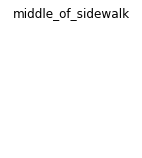

In [ ]:
labels_map = dict((v,k) for k,v in class_map.items())

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze())
plt.show()

Feature batch shape: torch.Size([32, 200, 400, 3])
Labels batch shape: torch.Size([32])


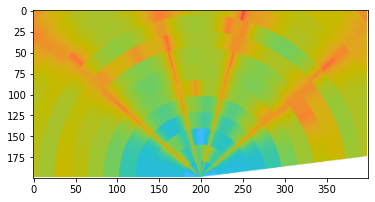

Label: 6
Class: tree


In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")
print(f"Class: {labels_map[label.item()]}")

In [ ]:
# Helper Functions to be Used Later

def compute_model_throughput(model, test_dataloader, batch_size):
  # Ref: https://deci.ai/resources/blog/measure-inference-time-deep-neural-networks/
  repetitions=50
  total_time = 0
  all_batch_throughputs = np.zeros(len(test_dataloader))

  with torch.no_grad():
    for batch_idx, (images, labels) in enumerate(test_dataloader):
      for rep in range(repetitions):
        images = images.cuda()  # move to GPU
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        starter.record()
        _ = model(images)
        ender.record()
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender) / 1000
        total_time += curr_time
      batch_throughput = (repetitions*batch_size) / total_time
      all_batch_throughputs[batch_idx] = batch_throughput

  return np.mean(all_batch_throughputs)  # samples / second


def compute_model_inference_time(model, test_dataloader, batch_size):
  # Ref: https://deci.ai/resources/blog/measure-inference-time-deep-neural-networks/
  # INIT LOGGERS
  starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
  repetitions = 50
  timings=np.zeros((repetitions,1))
  all_batch_times = np.zeros(len(test_dataloader))

  for batch_idx, (images, labels) in enumerate(test_dataloader):
    images = images.cuda()
    #GPU-WARM-UP
    for _ in range(10):
      _ = model(images)
    # MEASURE PERFORMANCE
    with torch.no_grad():
      for rep in range(repetitions):
        starter.record()
        _ = model(images)
        ender.record()
        # WAIT FOR GPU SYNC
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time
    mean_syn = np.sum(timings) / repetitions
    all_batch_times[batch_idx] = mean_syn

  return np.mean(all_batch_times)  # in milliseconds



---


#Training from Scratch with Custom CNN Model (Baseline)

In [ ]:
#@title
EPOCHS = 15
IS_GPU = True
TRAIN_BS = 32
VAL_BS = 5
TEST_BS = 5
TOTAL_CLASSES = 8

train_transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize([0,0,0], [1,1,1]), 
     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
     transforms.RandomHorizontalFlip()])

val_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0,0,0], [1,1,1])
     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
     ])

train_set = CustomDataset(data_path='Radar_PostProcess_Heatmaps/train', transform=train_transform)		
train_dataloader = DataLoader(train_set, batch_size=TRAIN_BS, shuffle=True, num_workers=2)
print(f'Train Set Size: {len(train_set)}')
print(f'Train Dataloader Size: {len(train_dataloader)}')

val_set = CustomDataset(data_path='Radar_PostProcess_Heatmaps/val', transform=val_transform)		
val_dataloader = DataLoader(val_set, batch_size=VAL_BS, shuffle=True, num_workers=2)
print(f'Val Set Size: {len(val_set)}')
print(f'Val Dataloader Size: {len(val_dataloader)}')

test_set = CustomDataset(data_path='Radar_PostProcess_Heatmaps/test', transform=val_transform)		
test_dataloader = DataLoader(test_set, batch_size=TEST_BS, shuffle=True, num_workers=2)
print(f'Test Set Size: {len(test_set)}')
print(f'Test Dataloader Size: {len(test_dataloader)}')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-8-043f89bdb6fc>", line 20, in <module>
    train_set = CustomDataset(data_path='Radar_PostProcess_Heatmaps/train', transform=train_transform)
  File "<ipython-input-6-ac39e5144edc>", line 26, in __init__
    for img_path in glob.glob(scenario_dir + '/' + scenario_dir_heatmaps_regex):
  File "/usr/lib/python3.7/glob.py", line 20, in glob
    return list(iglob(pathname, recursive=recursive))
  File "/usr/lib/python3.7/glob.py", line 72, in _iglob
    for name in glob_in_dir(dirname, basename, dironly):
  File "/usr/lib/python3.7/glob.py", line 80, in _glob1
    names = list(_iterdir(dirname, dironly))
  File "/usr/lib/python3.7/glob.py", line 121, in _iterdir
    with os.scandir(dirname) as it:
KeyboardInterrupt

During handling of the above exception, another exception occu

KeyboardInterrupt: ignored

#Transfer Learning with Pretrained Models

In [ ]:
models_map = {
    'resnet': 'resnet18',
    'vgg': 'vgg11',
    'squeezenet': 'squeezenet1_0',
    'mobilenet': 'mobilenetv2'
    }

class PreTrainedResNet(nn.Module):
  def __init__(self, num_classes, feature_extracting):
    super(PreTrainedResNet, self).__init__()
    
    #TODO1: Load pre-trained ResNet Model
    self.resnet18 = models.resnet18(pretrained=True)

    #Set gradients to false
    if feature_extracting:
      for param in self.resnet18.parameters():
          param.requires_grad = False
    
    #Replace last fc layer
    num_feats = self.resnet18.fc.in_features
    
    #TODO2: Replace fc layer in resnet to a linear layer of size (num_feats, num_classes)
    self.resnet18.fc = nn.Linear(num_feats, num_classes)
    
  def forward(self, x):
    #TODO3: Forward pass x through the model
    x = self.resnet18(x)

    return x


class PreTrainedVGGNet(nn.Module):
  def __init__(self, num_classes, feature_extracting):
    super(PreTrainedVGGNet, self).__init__()
    
    #TODO1: Load pre-trained VGGNet Model
    self.vgg11 = models.vgg11(pretrained=True)

    #Set gradients to false
    if feature_extracting:
      for param in self.vgg11.parameters():
          param.requires_grad = False
    
    #Replace output layer (Ref: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)
    self.vgg11.classifier[6] = nn.Linear(4096, num_classes)
    
  def forward(self, x):
    #TODO3: Forward pass x through the model
    x = self.vgg11(x)

    return x


class PreTrainedSqueezeNet(nn.Module):
  def __init__(self, num_classes, feature_extracting):
    super(PreTrainedSqueezeNet, self).__init__()
    
    #TODO1: Load pre-trained SqueezeNet Model
    self.squeezenet1_0 = models.squeezenet1_0(pretrained=True)

    #Set gradients to false
    if feature_extracting:
      for param in self.squeezenet1_0.parameters():
          param.requires_grad = False
    
    #TODO2: Replace output layer (Ref: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)
    self.squeezenet1_0.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
    self.squeezenet1_0.num_classes = num_classes
    
  def forward(self, x):
    #TODO3: Forward pass x through the model
    x = self.squeezenet1_0(x)

    return x


class PreTrainedMobileNet(nn.Module):
  def __init__(self, num_classes, class_dict, feature_extracting):
    super(PreTrainedMobileNet, self).__init__()
    
    #TODO1: Load pre-trained MobileNet Model
    self.mobilenet_v2 = models.mobilenet_v2(pretrained=True)
    self.class_dict = class_dict

    #Set gradients to false
    if feature_extracting:
      for param in self.mobilenet_v2.parameters():
          param.requires_grad = False
    
    #TODO2: Replace output layer (Ref: https://stackoverflow.com/questions/57285224/fine-tuning-pretrained-model-mobilenet-v2-in-pytorch)
    self.mobilenet_v2.classifier[1] = nn.Linear(self.mobilenet_v2.last_channel, num_classes)
    
  def forward(self, x):
    #TODO3: Forward pass x through the model
    x = self.mobilenet_v2(x)

    return x


In [ ]:
# Nothing to be edited in this cell
def calculate_val_accuracy(valloader, is_gpu):
    """ Util function to calculate val set accuracy,
    both overall and per class accuracy
    Args:
        valloader (torch.utils.data.DataLoader): val set 
        is_gpu (bool): whether to run on GPU
    Returns:
        tuple: (overall accuracy, class level accuracy)
    """    
    model.eval()
  
    correct = 0.0
    total = 0.
    predictions = []
    all_labels = []
    all_original_labels = []

    class_correct = torch.zeros(size=(TOTAL_CLASSES, 1)).cuda() 
    class_total = torch.zeros(size=(TOTAL_CLASSES,1)).cuda()
  
    with torch.no_grad():
        for batch_idx, (images, labels, original_labels) in enumerate(valloader):
          #move to GPU
          images, labels = images.cuda(), labels.cuda()
          total += labels.size(0)

          #forward
          outputs = model.forward(images)


          _, preds = torch.max(outputs.data, 1)
          predictions.extend(list(preds.cpu().numpy()))
          all_labels.append(labels)
          all_original_labels.append(original_labels)

          correct += (preds == labels).sum()
          #print('labels', torch.where(labels==class_map['middle_of_sidewalk'])[0])
          #print('predictions', torch.where(preds==class_map['middle_of_sidewalk'])[0])
          c = (preds == labels)
          for i in range(len(labels)):
              label = labels[i]
              class_correct[label] += c[i]
              class_total[label] += 1
        all_labels = torch.stack(all_labels)
        all_original_labels = torch.stack(all_original_labels)
        
        for object_class in model.class_dict.keys():
            idx = torch.where(all_original_labels == object_class)[0]
            instances = predictions[idx]
            target_instances = all_labels[idx]
            correct = (predictions == all_labels).sum()
            class_accuracy = (correct/instances.size(0))*100
        


    
    class_accuracy = torch.divide(class_correct, class_total).cpu().numpy()
    validation_acc = correct/total

    return validation_acc, class_accuracy


In [ ]:
def train(model, optimizer, scheduler, criterion, epoch, num_epochs, patience = 10):
  model.train()
  epoch_loss = 0.0
  epoch_acc = 0.0
  total = 0.
  

  
  for batch_idx, (images, labels, original_labels) in enumerate(train_dataloader):
    #zero the parameter gradients
    optimizer.zero_grad()
    
    #move to GPU
    images, labels = images.cuda(), labels.cuda()
    total += labels.size(0)
    
    #forward
    outputs = model.forward(images)
    
    loss = criterion(outputs, labels)
    
    _, preds = torch.max(outputs.data, 1)
    
    loss.backward()
    optimizer.step()
    scheduler.step()
    
    epoch_loss += loss.item()
    epoch_acc += torch.sum(preds == labels).item()
    
  epoch_loss /= len(train_dataloader)
  epoch_acc /= total

  # Calculate validation set accuracy of the existing model
  val_accuracy, val_classwise_accuracy = \
      calculate_val_accuracy(val_dataloader, IS_GPU)
  
  print(f'Epoch {epoch}/{num_epochs} Training Loss {epoch_loss} Training Accuracy {100*epoch_acc}% Validation Accuracy {100*val_accuracy}%')


  # Optionally print classwise accuracies
  for c_i in range(TOTAL_CLASSES):
    print(f'Accuracy of {labels_map[c_i]} : {100*val_classwise_accuracy[c_i]}%')
  return val_accuracy

def early_stop(val_accuracy, best_accuracy, patience, max_patience):
  if val_accuracy <= best_accuracy:
    return True
  return False


  

In [ ]:
#TODO: Vary Hyperparams

IS_GPU = True
NUM_EPOCHS = 15
LEARNING_RATE = 0.001
TRAIN_BS = 32
VAL_BS = 5
TEST_BS = 5
TOTAL_CLASSES = 8

train_transform = transforms.Compose(
    [transforms.ToTensor(), 
     #transforms.Normalize([0,0,0], [1,1,1]), 
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), 
     transforms.RandomHorizontalFlip()])

val_transform = transforms.Compose(
    [transforms.ToTensor(),
     #transforms.Normalize([0,0,0], [1,1,1])
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
     ])

train_set = CustomDataset(data_path='Radar_PostProcess_Heatmaps/train', transform=train_transform)		

train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)
print(f'Train Set Size: {len(train_set)}')
print(f'Train Dataloader Size: {len(train_dataloader)}')

val_set = CustomDataset(data_path='Radar_PostProcess_Heatmaps/val', transform=val_transform)		
val_dataloader = DataLoader(val_set, batch_size=5, shuffle=True, num_workers=2)
print(f'Val Set Size: {len(val_set)}')
print(f'Val Dataloader Size: {len(val_dataloader)}')

test_set = CustomDataset(data_path='Radar_PostProcess_Heatmaps/test', transform=val_transform)		
test_dataloader = DataLoader(test_set, batch_size=5, shuffle=True, num_workers=2)
print(f'Test Set Size: {len(test_set)}')
print(f'Test Dataloader Size: {len(test_dataloader)}')



Train Set Size: 2000
Train Dataloader Size: 63
Val Set Size: 526
Val Dataloader Size: 106
Test Set Size: 574
Test Dataloader Size: 115


In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]

#print('sample shape', img)


Feature batch shape: torch.Size([32, 3, 200, 400])
Labels batch shape: torch.Size([32])


##ResNet18

In [ ]:
RESNET_LAST_ONLY = False #Fine tunes only the last layer. Set to False to fine tune entire network
NUM_EPOCHS= 70
max_patience = 10
patience = max_patience
best_accuracy = -100000
warmup = 10
labels_map = dict((v,k) for k,v in class_map.items())
model_name = models_map['resnet']

#Initialize the model
model = PreTrainedResNet(TOTAL_CLASSES, RESNET_LAST_ONLY)
model = model.cuda()
model_total_params = sum(p.numel() for p in model.parameters())
print(f'Total Params: {model_total_params}')

#Setting the optimizer and loss criterion
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.2)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=500)
criterion = nn.CrossEntropyLoss()

#Begin Train
for epoch in range(NUM_EPOCHS):
  val_accuracy = train(model, optimizer, scheduler, criterion, epoch+1, NUM_EPOCHS)
  if epoch == 0 or epoch >= warmup:
    if val_accuracy <= best_accuracy:
      patience -=1
    else:
      best_accuracy = val_accuracy
      patience = max_patience
      print('Saving Model')
      torch.save(model.state_dict(), f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}chkpt{epoch}.pth')
      load_from = epoch
      print('Model Saved')
    if patience == 0:
      print(f"Validation accuracy did not improve in {max_patience} epochs, early stopping")
      break
  
print(f"Finished Training: best performing model at epoch {load_from}")
print("-"*10)

print('Saving Model')
model_name = models_map['resnet']
torch.save(model.state_dict(), f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}.pth')
print('Model Saved')

# Load saved model and run throughput and inference tests of model on test set
saved_model = PreTrainedResNet(TOTAL_CLASSES, RESNET_LAST_ONLY)
saved_model.load_state_dict(torch.load(f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}.pth'))
saved_model = saved_model.cuda()
saved_model.eval()

tp = compute_model_throughput(saved_model, test_dataloader, TEST_BS)
print(f'Avg Throughput of Model on Test Images: {tp} images/s')
time = compute_model_inference_time(saved_model, test_dataloader, TEST_BS)
print(f'Avg Inference Time of Model on Test Images: {time} ms')

Total Params: 11180616
Epoch 1/70 Training Loss 1.0727002790996008 Training Accuracy 61.7% Validation Accuracy 14.068441390991211%
Accuracy of bicyclerack : [0.]%
Accuracy of bush : [0.]%
Accuracy of firehydrant : [0.]%
Accuracy of human : [0.]%
Accuracy of lamppost : [98.24561]%
Accuracy of middle_of_sidewalk : [0.]%
Accuracy of tree : [0.]%
Accuracy of wall : [19.565218]%
Saving Model
Model Saved
Epoch 2/70 Training Loss 1.1335357683045524 Training Accuracy 57.15% Validation Accuracy 12.357414245605469%
Accuracy of bicyclerack : [0.]%
Accuracy of bush : [0.]%
Accuracy of firehydrant : [0.]%
Accuracy of human : [0.]%
Accuracy of lamppost : [100.]%
Accuracy of middle_of_sidewalk : [0.]%
Accuracy of tree : [0.]%
Accuracy of wall : [8.695652]%
Epoch 3/70 Training Loss 1.112493165901729 Training Accuracy 58.25% Validation Accuracy 12.547529220581055%
Accuracy of bicyclerack : [0.]%
Accuracy of bush : [100.]%
Accuracy of firehydrant : [0.]%
Accuracy of human : [0.]%
Accuracy of lamppost : 

In [ ]:
model_name = models_map['resnet']
labels_map = dict((v,k) for k,v in class_map.items())
model = PreTrainedResNet(TOTAL_CLASSES, False)
if not torch.cuda.is_available():
  device = torch.device('cpu')
  IS_GPU=False
else:
  device = torch.device('cuda:0')
  IS_GPU=True

print(device)

model.load_state_dict(torch.load(f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}chkpt{load_from}.pth'))
model.eval()
if IS_GPU:    
  model.cuda()

test_accuracy, test_classwise_accuracy = \
      calculate_val_accuracy(test_dataloader, IS_GPU)

print(f'test accuracy: {100*test_accuracy}')

for c_i in range(TOTAL_CLASSES):
  print(f'Accuracy of {labels_map[c_i]} : {100*test_classwise_accuracy[c_i]}%')

cuda:0


FileNotFoundError: ignored

##VGGNet

In [ ]:
VGGNET_LAST_ONLY = False

#Initialize the model
model = PreTrainedVGGNet(TOTAL_CLASSES, VGGNET_LAST_ONLY)
model = model.cuda()
model_total_params = sum(p.numel() for p in model.parameters())
print(f'Total Params: {model_total_params}')

#Setting the optimizer and loss criterion
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
criterion = nn.CrossEntropyLoss()

#Begin Train
for epoch in range(NUM_EPOCHS):
  train(model, optimizer, criterion, epoch+1, NUM_EPOCHS)
  
print("Finished Training")
print("-"*10)

print('Saving Model')
model_name = models_map['vgg']
torch.save(model.state_dict(), f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}.pth')
print('Model Saved')

# Load saved model and run throughput and inference tests of model on test set
saved_model = PreTrainedVGGNet(TOTAL_CLASSES, VGGNET_LAST_ONLY)
saved_model.load_state_dict(torch.load(f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}.pth'))
saved_model = saved_model.cuda()
saved_model.eval()

tp = compute_model_throughput(saved_model, test_dataloader, TEST_BS)
print(f'Avg Throughput of Model on Test Images: {tp} images/s')
time = compute_model_inference_time(saved_model, test_dataloader, TEST_BS)
print(f'Avg Inference Time of Model on Test Images: {time} ms')

##SqueezeNet 1.0

In [ ]:
SQUEEZENET_LAST_ONLY = False


#Initialize the model
model = PreTrainedSqueezeNet(TOTAL_CLASSES, SQUEEZENET_LAST_ONLY)
model = model.cuda()
model_total_params = sum(p.numel() for p in model.parameters())
print(f'Total Params: {model_total_params}')

#Setting the optimizer and loss criterion
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
criterion = nn.CrossEntropyLoss()

#Begin Train
for epoch in range(NUM_EPOCHS):
  train(model, optimizer, criterion, epoch+1, NUM_EPOCHS)
  
print("Finished Training")
print("-"*10)

print('Saving Model')
model_name = models_map['squeezenet']
torch.save(model.state_dict(), f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}.pth')
print('Model Saved')

# Load saved model and run throughput and inference tests of model on test set
saved_model = PreTrainedSqueezeNet(TOTAL_CLASSES, SQUEEZENET_LAST_ONLY)
saved_model.load_state_dict(torch.load(f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}.pth'))
saved_model = saved_model.cuda()
saved_model.eval()

tp = compute_model_throughput(saved_model, test_dataloader, TEST_BS)
print(f'Avg Throughput of Model on Test Images: {tp} images/s')
time = compute_model_inference_time(saved_model, test_dataloader, TEST_BS)
print(f'Avg Inference Time of Model on Test Images: {time} ms')

##MobileNetv2

In [ ]:
MOBILENET_LAST_ONLY = False
NUM_EPOCHS= 70
max_patience = 10
patience = max_patience
best_accuracy = -100000
warmup = 10
load_from = NUM_EPOCHS-1
labels_map = dict((v,k) for k,v in class_map.items())

#Initialize the model
model = PreTrainedMobileNet(TOTAL_CLASSES, MOBILENET_LAST_ONLY)
model = model.cuda()
model_total_params = sum(p.numel() for p in model.parameters())
print(f'Total Params: {model_total_params}')

#Setting the optimizer and loss criterion
#optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.2)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=500)
criterion = nn.CrossEntropyLoss()
##TODO  weight decay, dropout, selectively unfreezing layers, early stopping

#Begin Train
for epoch in range(NUM_EPOCHS):
  val_accuracy = train(model, optimizer, scheduler, criterion, epoch+1, NUM_EPOCHS)
  if epoch == 0 or epoch >= warmup:
    if val_accuracy <= best_accuracy:
      patience -=1
    else:
      best_accuracy = val_accuracy
      patience = max_patience
      print('Saving Model')
      model_name = models_map['mobilenet']
      torch.save(model.state_dict(), f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}chkpt{epoch}.pth')
      load_from = epoch
      print('Model Saved')
    if patience == 0:
      print(f"Validation accuracy did not improve in {max_patience} epochs, early stopping")
      break
  
print(f"Finished Training: best performing model at epoch {load_from}")
print("-"*10)

#print('Saving Model')
#model_name = models_map['mobilenet']
#torch.save(model.state_dict(), f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}.pth')
#print('Model Saved')

# Load saved model and run throughput and inference tests of model on test set
saved_model = PreTrainedMobileNet(TOTAL_CLASSES, MOBILENET_LAST_ONLY)
saved_model.load_state_dict(torch.load(f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}chkpt{load_from}.pth'))
saved_model = saved_model.cuda()
saved_model.eval()

tp = compute_model_throughput(saved_model, test_dataloader, TEST_BS)
print(f'Avg Throughput of Model on Test Images: {tp} images/s')
time = compute_model_inference_time(saved_model, test_dataloader, TEST_BS)
print(f'Avg Inference Time of Model on Test Images: {time} ms')

In [ ]:
load_from = 18


In [ ]:

model_name = models_map['mobilenet']
labels_map = dict((v,k) for k,v in class_map.items())
model = PreTrainedMobileNet(TOTAL_CLASSES, False)
if not torch.cuda.is_available():
  device = torch.device('cpu')
  IS_GPU=False
else:
  device = torch.device('cuda:0')
  IS_GPU=True

print(device)

model.load_state_dict(torch.load(f'/content/gdrive/MyDrive/CS498 RF & IMU monitoring of electric scooter driving behaviour/models/{model_name}chkpt{load_from}.pth'))
model.eval()
if IS_GPU:    
  model.cuda()

test_accuracy, test_classwise_accuracy = \
      calculate_val_accuracy(test_dataloader, IS_GPU)

print(f'test accuracy: {100*test_accuracy}')

for c_i in range(TOTAL_CLASSES):
  print(f'Accuracy of {labels_map[c_i]} : {100*test_classwise_accuracy[c_i]}%')



Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

cuda:0
test accuracy: 57.49129104614258
Accuracy of bicyclerack : [100.]%
Accuracy of bush : [89.79591]%
Accuracy of firehydrant : [46.153847]%
Accuracy of human : [1.754386]%
Accuracy of lamppost : [32.55814]%
Accuracy of middle_of_sidewalk : [56.25]%
Accuracy of tree : [22.]%
Accuracy of wall : [90.74074]%


##Visualize Predicted vs Actual for Some Test Heatmaps

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(1)  # pause a bit so that plots are updated
    
def visualize_model(model, class_names, num_images=8):
    images_so_far = 0
    fig = plt.figure()

    for batch_idx, (images, labels) in enumerate(test_dataloader):
        #move to GPU
        images, labels = images.cuda(), labels.cuda()
        
        outputs = model(images)
        
        _, preds = torch.max(outputs.data, 1)
       

        for j in range(images.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('class: {} predicted: {}'.format(class_names[labels.data[j]], class_names[preds[j]]))

            imshow(images.cpu().data[j])

            if images_so_far == num_images:
                return

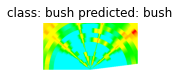

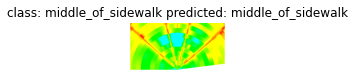

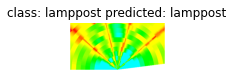

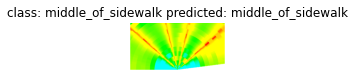

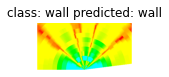

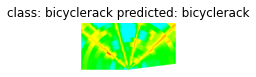

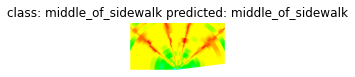

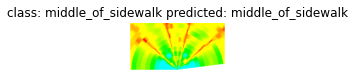

In [ ]:
class_names = list(class_map.keys())
visualize_model(model, class_names, 8)